# Internal Tide and BALanced Turbulence configuration (ITBALT), overview

Next things to try:

...

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:59746 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


## Load data

In [3]:
root_path = '/home1/scratch/aponte/'
#root_path = '/home/c11-data/Test_aponte/fsturb/'
#run = 'fsturb_4km_dt1d_0a1000j_relax/'
run = 'fsturb_4km_0a1000j_a1/'

#r = pp.Run(root_path+run, prefix='file_', open_nc=['surf'], verbose=True)
r = pp.Run(root_path+run, open_nc=['surf'], tdir_max= 8,verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home1/scratch/aponte/fsturb_4km_0a1000j_a1/
Found 8 segments
Found 8 grid files
Found 16 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


---

## utils

In [4]:
def plot_Fy(r, ax=None, scale=1, ls='--', color='k', **kwargs):
    p = r.params_output
    ymid = p['fst_ymid']*scale
    ywid = p['fst_ywid']*scale
    if ax is not None:
        ax.axhline(ymid-ywid, ls=ls, color=color)
        ax.axhline(ymid+ywid, ls=ls, color=color)
    else:
        plt.axhline(ymid+ywid, ls=ls, color=color)
        plt.axhline(ymid-ywid, ls=ls, color=color)

---

## bulk statistics

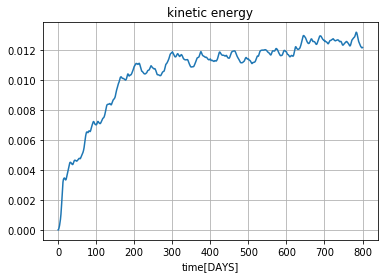

In [5]:
ax = r.stats['KINETIC_ENRG'].plot(title='kinetic energy')
ax.grid()

In [6]:
ds = r['surf']
ds['u2'] = ds.u**2
ds['v2'] = ds.v**2
ds_mean = ds.mean(dim=['x_rho','x_u','time']).persist()

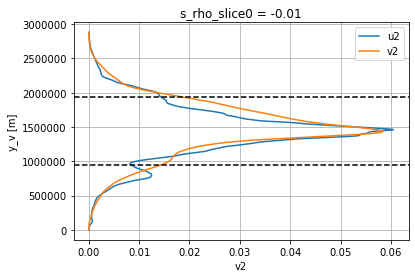

In [7]:
ax = plt.subplot(111)
ds_mean.u2.plot(y='y_rho', ax=ax, label='u2')
ds_mean.v2.plot(y='y_v', ax=ax, label='v2')
ax.legend()
ax.grid()
plot_Fy(r)

In [8]:
u2_meanx = (r['surf'].u**2).mean(dim=['x_u']).persist()

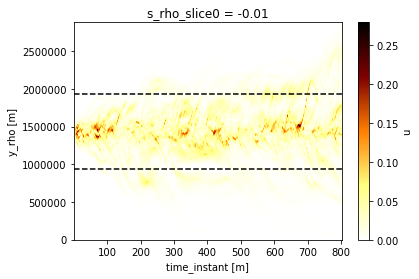

In [9]:
u2_meanx.plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape
plot_Fy(r)

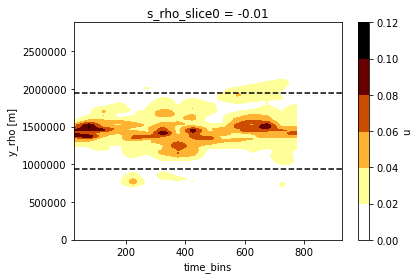

In [10]:
toplt = u2_meanx.groupby_bins('time',np.arange(0,1000,50)).mean('time').squeeze()
toplt.time_bins.values = [t.values.item().mid for t in toplt.time_bins] # contourf won't work otherwise
toplt.plot.contourf(x='time_bins', y='y_rho', cmap='afmhot_r')
plot_Fy(r)

--- 

## pictures

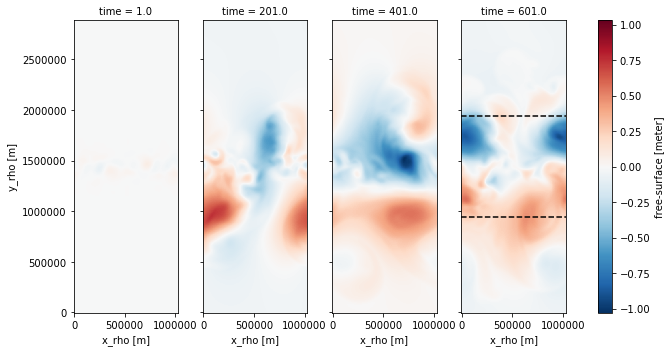

In [11]:
hdl = (r['surf']['ssh'].sel(time=slice(0,1000,200))
         .plot(x='x_rho', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(r, ax=hdl.axes[0,-1])

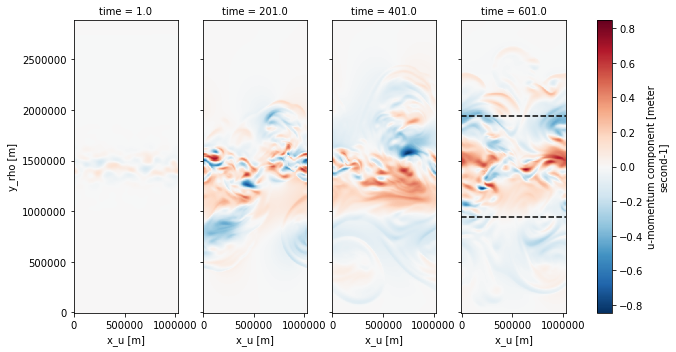

In [12]:
hdl = (r['surf']['u'].sel(time=slice(0,1000,200))
         .plot(x='x_u', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(r, ax=hdl.axes[0,-1])

In [13]:
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

AttributeError: 'Grid' object has no attribute '_metrics'

In [14]:
# hardcode derivative: not ideal
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.diff(u, 'eta') + r.xgrid.diff(v, 'xi'))/4e3

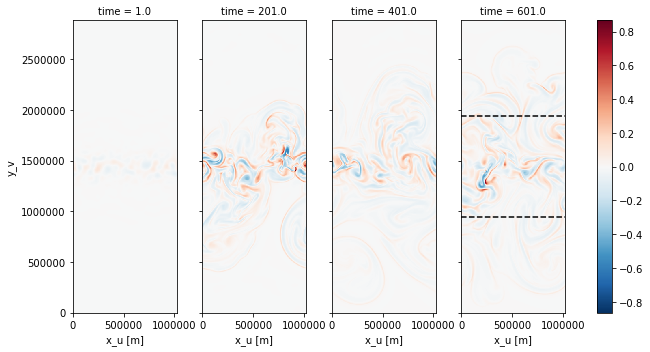

In [15]:
f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
hdl = ((zeta/f_zeta).sel(time=slice(0,1000,200))
         .plot(x='x_u', y='y_v', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(r, ax=hdl.axes[0,-1])

---

## wavenumber spectra with xrft

In [45]:
u = r['surf']['u'].sel(time=slice(0,None,5))
v = r['surf']['v'].sel(time=slice(0,None,5))

In [46]:
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2).mean('time').persist()
ekehat

<xarray.DataArray (freq_y_rho: 722, freq_x_rho: 258)>
array([[1.50744320e-06, 1.13500091e-05, 4.31285605e-05, ...,
        1.20566056e-04, 4.31285605e-05, 1.13500091e-05],
       [3.08320265e-06, 1.31572264e-05, 4.59608535e-05, ...,
        1.21270763e-04, 4.34249601e-05, 1.24181628e-05],
       [7.73909594e-06, 1.72981224e-05, 5.13892763e-05, ...,
        1.25034844e-04, 4.70840794e-05, 1.66898444e-05],
       ...,
       [1.52147453e-05, 2.36963518e-05, 5.32714042e-05, ...,
        1.41060855e-04, 5.91309025e-05, 2.35502514e-05],
       [7.73909594e-06, 1.66898444e-05, 4.70840794e-05, ...,
        1.31846940e-04, 5.13892763e-05, 1.72981224e-05],
       [3.08320265e-06, 1.24181628e-05, 4.34249601e-05, ...,
        1.24772724e-04, 4.59608535e-05, 1.31572264e-05]])
Coordinates:
  * freq_y_rho          (freq_y_rho) float64 -0.000125 -0.0001247 ... 0.0001247
  * freq_x_rho          (freq_x_rho) float64 -0.000125 -0.000124 ... 0.000124
    freq_x_rho_spacing  float64 9.69e-07
    freq_y_rho_spacing  float64 3.463e-07

In [47]:
kx = (ekehat['freq_x_rho']*1e3).rename('kx [km]')
ky = (ekehat['freq_y_rho']*1e3).rename('ky [km]')

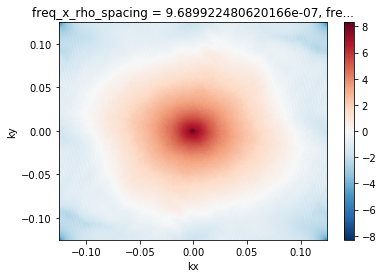

In [48]:
np.log10(ekehat.assign_coords(kx=kx, ky=ky)).plot(x='kx', y='ky') #, subplot_kws={'aspect':'equal'}, aspect=.5, figsize=(5,5))

In [49]:
ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)

/home1/datahome/aponte/xrft/xrft/xrft.py:608: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/home1/datahome/aponte/xrft/xrft/xrft.py:624: RuntimeWarning: invalid value encountered in true_divide
  iso_f = np.ma.masked_invalid(_bincount / area) * kr


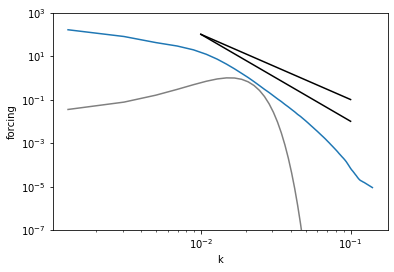

In [50]:
ekehat_iso.plot(x='k', xscale='log', yscale='log')

# get forcing wavenumbers
F_k = 1e3*r.params_output['fst_k']
F_dk = 1e3*r.params_output['fst_dk']
F = np.exp(-((ekehat_iso.k-F_k)/F_dk)**2).rename('forcing')

F.plot(x='k', xscale='log', yscale='log', 
                           ylim=(1e-7, 1e3), color='0.5')

kref = np.array([1e-2, 1e-1])
plt.plot(kref, 1e2*(kref[0]/kref)**3, 'k')
plt.plot(kref, 1e2*(kref[0]/kref)**4, 'k')

In [22]:
u = r['surf']['u'].sel(time=slice(0,100,10))
v = r['surf']['v'].sel(time=slice(0,100,10))
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2)

ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)
ekehat_iso = ekehat_iso.persist()

/home1/datahome/aponte/xrft/xrft/xrft.py:608: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/home1/datahome/aponte/xrft/xrft/xrft.py:624: RuntimeWarning: invalid value encountered in true_divide
  iso_f = np.ma.masked_invalid(_bincount / area) * kr


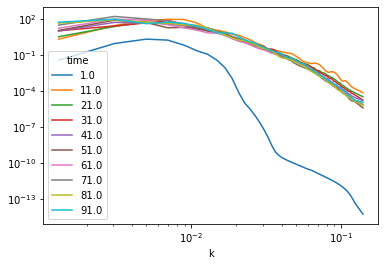

In [23]:
hdl = ekehat_iso.plot(x='k', hue='time', xscale='log', yscale='log')

#F.plot(x='k', xscale='log', yscale='log', 
#                           ylim=(1e-7, 1e3), color='0.5')

In [24]:
r.params_output

{'jet_ywidth': 800000.0,
 'jet_weight': 0.0,
 'tdiag_omega': 0.000145,
 'depth': 4000.0,
 'f0': 0.000103,
 'beta': 0.0,
 'yrbeta': 1440000.0,
 'fst_dt': 864000.0,
 'fst_tdecay': 77800000.0,
 'fst_Nmode': 5.0,
 'fst_a': array([0.1, 0.1, 0.1, 0.1, 0.1]),
 'fst_xmid': 512000.0,
 'fst_xwid': 200000.0,
 'fst_ymid': 1440000.0,
 'fst_ywid': 500000.0,
 'fst_FT': 100.0,
 'fst_k': 1.56e-05,
 'fst_dk': 7.81e-06}

---

In [51]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1283, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1012, in _reconnect
    await self._close()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/cli